# Cell Grading

This notebook contains code to grade cells based on QV AUC, SOC-V Knee points and Max Capacity.

In [1]:
import pandas as pd
from pathlib import Path

base = Path("/home/kcv/Desktop/Rate_Capability")
qv_path = base / "results/data/qv_auc_summary.csv"
soc_knee_path = base / "results/data/soc_knee_summary.csv"
soc_data_dir = base / "results/data/soc_data"
output_path = base / "results/data/qv_soc_knee_capacity_summary.csv"

# 1. Load the two summaries
qv_df = pd.read_csv(qv_path)
soc_df = pd.read_csv(soc_knee_path)

# 2. Merge them on cell/cycle/step info
summary = qv_df.merge(
    soc_df,
    on=["cell_name", "cycle_no", "step_no", "step_name"],
    how="outer",
    suffixes=("_qv", "_soc")
)

# 3. Build abs-max-capacity per cell/cycle/step from the SoC data exports
capacity_frames = []
for soc_file in soc_data_dir.glob("*_soc_data.csv"):
    cell_name = soc_file.stem.replace("_soc_data", "")
    df = pd.read_csv(soc_file)
    df["cell_name"] = cell_name
    df["abs_capacity"] = df["capacity(ah)"].abs()
    agg = (
        df.groupby(["cell_name", "cycle no", "step no", "step name"], as_index=False)["abs_capacity"]
          .max()
          .rename(columns={
              "cycle no": "cycle_no",
              "step no": "step_no",
              "step name": "step_name",
              "abs_capacity": "abs_max_capacity"
          })
    )
    capacity_frames.append(agg)

capacity_df = pd.concat(capacity_frames, ignore_index=True)

# 4. Merge the abs-capacity info into the combined summary
summary = summary.merge(
    capacity_df,
    on=["cell_name", "cycle_no", "step_no", "step_name"],
    how="left"
)

# 5. Save the final summary
summary.to_csv(output_path, index=False)
print(f"Saved combined summary to {output_path}")


Saved combined summary to /home/kcv/Desktop/Rate_Capability/results/data/qv_soc_knee_capacity_summary.csv


<Figure size 1100x1100 with 0 Axes>

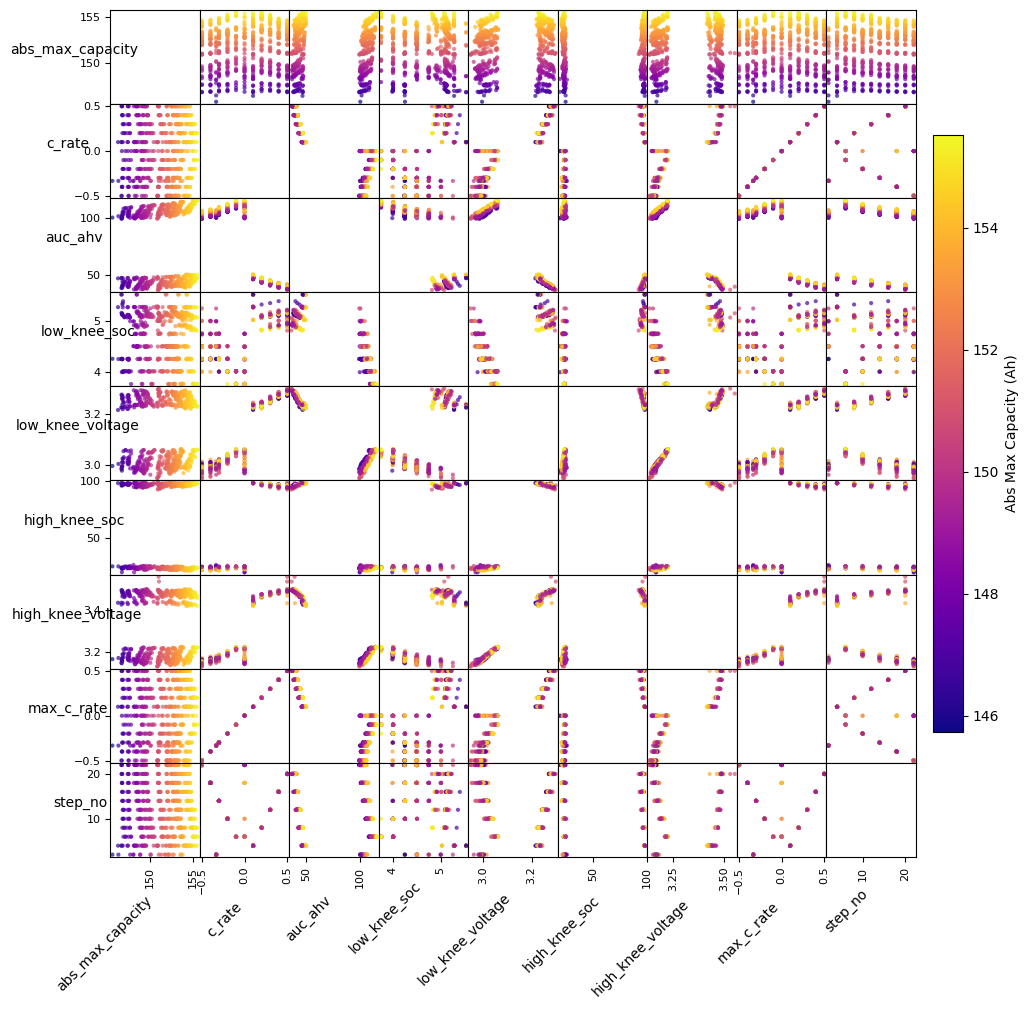

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pathlib import Path

summary = pd.read_csv(Path("results/data/qv_soc_knee_capacity_summary.csv"))

numeric_cols = [
    "abs_max_capacity",
    "c_rate",
    "auc_ahv",
    "low_knee_soc",
    "low_knee_voltage",
    "high_knee_soc",
    "high_knee_voltage",
    "max_c_rate",
    "step_no",
]

feat_df = summary[numeric_cols].dropna().reset_index(drop=True)

abs_cap = feat_df["abs_max_capacity"]
norm = plt.Normalize(abs_cap.min(), abs_cap.max())
cmap = plt.cm.plasma
colors = cmap(norm(abs_cap))

fig = plt.figure(figsize=(11, 11))
axes = scatter_matrix(
    feat_df,
    figsize=(11, 11),
    diagonal=None,
    color=colors,
    alpha=0.7
)

for ax in axes.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha="right")
    ax.set_ylabel(ax.get_ylabel(), rotation=0)

fig.subplots_adjust(right=0.9, top=0.92, bottom=0.08)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes, fraction=0.035, pad=0.02, label="Abs Max Capacity (Ah)")
fig.savefig(out_dir / f"step_{step_no}_corr.png")

fig.suptitle("Pair Plot – Capacity/Knee Features (Colored by Abs Max Capacity)", y=0.98)
plt.show()


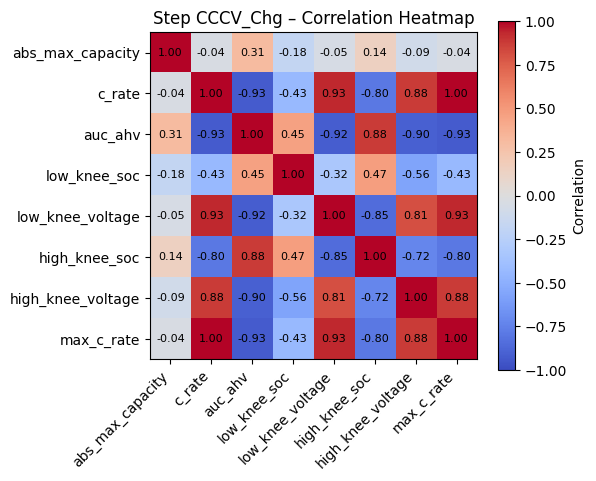

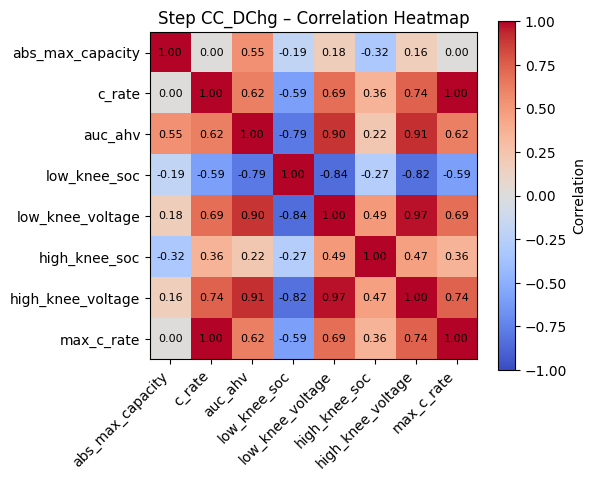

Saved per-step correlation heatmaps (with coefficients) under results/plots/step_corr.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

summary = pd.read_csv("results/data/qv_soc_knee_capacity_summary.csv")

features = [
    "abs_max_capacity",
    "c_rate",
    "auc_ahv",
    "low_knee_soc",
    "low_knee_voltage",
    "high_knee_soc",
    "high_knee_voltage",
    "max_c_rate",
]

out_dir = Path("results/plots/step_corr")
out_dir.mkdir(parents=True, exist_ok=True)

for step_no, group in summary.groupby("step_name"):
    feat_df = group[features].dropna()
    if feat_df.empty:
        continue

    corr = feat_df.corr()

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(features)
    ax.set_title(f"Step {step_no} – Correlation Heatmap")

    # Annotate each cell with the coefficient
    for i in range(len(features)):
        for j in range(len(features)):
            ax.text(
                j, i,
                f"{corr.values[i, j]:.2f}",
                ha="center",
                va="center",
                color="black",
                fontsize=8,
            )

    fig.colorbar(im, ax=ax, label="Correlation")
    plt.tight_layout()
    fig.savefig(out_dir / f"step_{step_no}_corr.png")
    plt.show()

print(f"Saved per-step correlation heatmaps (with coefficients) under {out_dir}.")
